Copyright (C) 2024 Pablo Castells y Alejandro Bellogín

El código que contiene este notebook se ha implementado para la realización de las prácticas de la asignatura "Sistemas de recomendación" del Máster en Ciencia de Datos, impartido en la Escuela Politécnica Superior de la Universidad Autónoma de Madrid. El fin del mismo, así como su uso, se ciñe a las actividades docentes de dicha asignatura.

### **Sistemas de recomendación 2024-25**
### Universidad Autónoma de Madrid, Escuela Politécnica Superior
### Máster en Ciencia de Datos

# Filtrado colaborativo con aprendizaje profundo: EASE, Two-Tower, Transformers

Fechas:

* Comienzo: martes 25 de febrero.
* Entrega: lunes 17 de marzo, 23:59.

## Objetivos

Esta práctica tiene por objetivo comprender el diseño de métodos de filtrado colaborativo mediante deep learning como transición desde un modelo bilineal típico de factorización de matrices hacia modelos neuronales de complejidad arbitraria. En este bloque se desarrollarán:

* Algoritmos de filtrado colaborativo basados en aprendizaje profundo.
* Algoritmos de filtrado colaborativo orientados a datos secuenciales.
* Métricas de evaluación de sistemas de recomendación.

## Material proporcionado

Al igual que en la P1, se proporcionan software y datos para la realización de la práctica:

* Algunas estructuras de datos ya implementadas, para manejar datos de ratings y la salida de los recomendadores.
* Un esqueleto de clases y funciones donde el estudiante desarrollará sus implementaciones. 
  - Se proporciona una celda de prueba al final de este notebook que deberá funcionar con las implementaciones del estudiante.
  - Junto a la celda de prueba en este mismo notebook, se muestra como referencia un ejemplo de salida generada con una implementación de los profesores.
* Los mismos conjuntos de datos de ratings que se usaban en la P1:
  - Dos conjuntos de juguete para prueba y depuración: <ins>toy1.csv</ins> y <ins>toy2.csv</ins> con ratings ficticios.
  - Un conjunto de datos reales de ratings a películas: *ml-1m.zip* disponible en la Web de [MovieLens](https://grouplens.org/datasets/movielens/1m). De los archivos disponibles, se utilizará sólamente <ins>ratings.dat</ins>, añadiéndole una cabecera `u::i::r::t`.
  
Los esqueletos de código que se proporcionan aquí son a modo de guía: el estudiante puede modificarlo todo libremente, siempre que la celda de prueba funcione correctamente **sin cambios**.

En concreto, si para la P1 el estudiante ya hubiera hecho cambios en alguna de estas clases, puede continuar usando dichas modificaciones.

La entrega consistirá en un fichero tipo *notebook* donde se incluirán todas las **implementaciones** solicitadas en cada ejercicio, así como una explicación de cada uno a modo de **memoria**.

La celda de prueba deberá ejecutar sin errores a la primera con el código entregado por el estudiante (naturalmente con salvedad de los ejercicios que no se hayan implementado).

## Estructuras de datos: ratings y recomendaciones

Se proporcionan:
* Una clase Ratings que permite leer los datos de un fichero de texto, así como un método que genera dos particiones (de forma <b>aleatoria</b> o <b>temporal</b>) de entrenamiento y test, para evaluar y comparar la efectividad de diferentes algoritmos de recomendación.
* Se pueden reutilizar las clases Recommender y Recommendation de la práctica anterior.

In [1]:
import numpy as np
import pandas as pd

class Ratings:
    def __init__(self, file=None, sep=','):
        if file:
            data = pd.read_csv(file, delimiter=sep, engine='python')
            u, i, r, t = data.columns[0:4]
            data.r = 1
            self.m = data.pivot(index=u, columns=i, values=r).fillna(0).to_numpy(dtype=np.float32)
            self.mt = data.pivot(index=u, columns=i, values=t).fillna(-1).to_numpy(dtype=np.float32)
            self.uids = np.sort(data[u].unique())
            self.iids = np.sort(data[i].unique())
            self.uidxs = {u:j for j, u in enumerate(self.uids)}
            self.iidxs = {i:j for j, i in enumerate(self.iids)}
            self._nratings = (self.m > 0).sum()
            self.data = data
        
    def copy(self, ratings, matrix, temp_matrix):
        self.m = matrix
        self.mt = temp_matrix
        self.uids = ratings.uids
        self.iids = ratings.iids
        self.uidxs = ratings.uidxs
        self.iidxs = ratings.iidxs
        self._nratings = (matrix > 0).sum()
        dfr = pd.DataFrame(columns=self.iids, index=self.uids, data=self.m).unstack().reset_index(name='r')
        dfr.columns = ['i', 'u', 'r']
        dft = pd.DataFrame(columns=self.iids, index=self.uids, data=self.mt).unstack().reset_index(name='t')
        dft.columns = ['i', 'u', 't']
        df_key = ['u','i']
        df = pd.concat([dfr.set_index(df_key).squeeze(), dft.set_index(df_key).squeeze()], keys = ['r','t'],axis=1).fillna(0).reset_index()
        self.data = df[df.r>0][['u', 'i', 'r', 't']].sort_values(by=['u', 'i'])
        return self
    
    def matrix(self):
        return self.m

    def temporal_matrix(self):
        return self.mt

    def nusers(self):
        return len(self.uids)
    
    def nitems(self):
        return len(self.iids)
    
    # uidx can be an int or an array-like of ints.
    def uidx_to_uid(self, uidx):
        return self.uids[uidx]
        
    # iidx can be an int or an array-like of ints.
    def iidx_to_iid(self, iidx):
        return self.iids[iidx]
    
    def uid_to_uidx(self, uid):
        return self.uidxs[uid]
        
    def iid_to_iidx(self, iid):
        return self.iidxs[iid]
        
    def iidx_rated_by(self, uidx):
        self.m[uidx].nonzero()
        
    def uidx_who_rated(self, iidx):
        self.m[:, iidx].nonzero()
        
    def random_split(self, ratio):
        mask = np.random.choice([True, False], size=self.m.shape, p=[ratio, 1-ratio])
        train = self.m * mask
        temp_train = self.mt * mask
        test = self.m * ~mask
        temp_test = self.mt * ~mask
        return Ratings().copy(self, train, temp_train), Ratings().copy(self, test, temp_test)
    
    def peruser_sequence_split(self, ntestitems=1):
        test_ids_arr = [group.sort_values(by='t', ascending=False)[['u', 'i']].to_numpy() 
                    for _, group in self.data.groupby(by='u')]
        test_ids = []
        for user_arr in test_ids_arr:
            for ids in user_arr[:ntestitems]:
                test_ids.append(ids)
        #print(test_ids)
        test_idx = np.array([[self.uid_to_uidx(uid), self.iid_to_iidx(iid)] for uid, iid in test_ids])
        mask = np.ones(self.matrix().shape)
        mask[test_idx[:, 0], test_idx[:, 1]] = 0
        train = self.m * mask
        temp_train = self.mt * mask
        test = self.m * (1-mask)
        temp_test = self.mt * (1-mask)
        return Ratings().copy(self, train, temp_train), Ratings().copy(self, test, temp_test)
    
    #
    # The remaining functions are just for debugging purposes.
    #

    def rating(self, uid, iid):
        return self.matrix()[self.uid_to_uidx(uid), self.iid_to_iidx(iid)]

    def items_rated_by(self, uid):
        return self.iidx_to_iid(self.iidx_rated_by(self.uid_to_uidx(uid)))
        
    def users_who_rated(self, iid):
        return self.uidx_to_uid(self.uidx_who_rated(self.iid_to_iidx(iid)))
    
    def user_ratings(self, uid):
        iidxs = self.matrix()[self.uid_to_uidx(uid)].nonzero()[0]
        return {self.iidx_to_iid(iidx): fround(r) for iidx, r in zip(iidxs, self.matrix()[self.uid_to_uidx(uid), iidxs])}

    def item_ratings(self, iid):
        uidxs = self.matrix()[:, self.iid_to_iidx(iid)].nonzero()[0]
        return {self.uidx_to_uid(uidx): fround(r) for uidx, r in zip(uidxs, self.matrix()[uidxs, self.iid_to_iidx(iid)])}

    def nratings(self):
        return self._nratings
    
from itertools import islice

# Given a matrix, returns a matrix of positions of top k values per row.
def top_positions_per_row(m, k):
    return np.argpartition(m, -k)[:, -k:]

class Recommendation:
    def __init__(self, scores, n, training):
        scores = scores * (training.matrix() == 0) # Don't recommend rated items.
        # We sort the positions in top_iidx just in order to keep the NumPy tie break by original position 
        # (i.e. by ascending object ID) when we use this function later.
        top_iidx = np.sort(top_positions_per_row(scores, min(n, training.nitems())))
        # We sort by -scores because NumPy sorts by ascending and we want descending.
        self.iidx_ranking = np.take_along_axis(top_iidx, np.argsort(-np.take_along_axis(scores, top_iidx, axis=1)), axis=1)
        self.rank_scores = np.take_along_axis(scores, self.iidx_ranking, axis=1)
        ranked_iids = training.iidx_to_iid(self.iidx_ranking)
        self._recommendation = {training.uidx_to_uid(uidx) : [(iid, score) for iid, score in zip(ranked_iids[uidx], self.rank_scores[uidx]) if score > 0]
                                for uidx in range(training.nusers())}

    def ranked_iidx(self):
        return self.iidx_ranking
        
    def recommendation(self, uid):
        return self._recommendation[uid]
        
    # This function is for debuggind purposes.
    # Format the recommendation as a string for the first n users. Trim scores to 4 decimal digits.
    def display(self, n):
        r = ''
        for uid in islice(self._recommendation, n):
            r += f'    User {uid} -> <' 
            for iid, score in self.recommendation(uid): 
                r += f'{iid}:{str(fround(score, 4))} '
            r = (r[:-1] + '>\n') if len(self.recommendation(uid)) > 0 else r + 'empty>\n'
        return r[:-1]
    
class Recommender():
    def __init__(self, training):
        self.training = training

    def __repr__(self):
        return type(self).__name__

    def recommend(self, n):
        return Recommendation(self.scores, n, self.training)

# Just for pretty-printing numbers.
def fround(x, n=20):
    r = round(x)
    rn = round(x, n)
    return r if rn == r else rn
 

## Ejercicio 1: EASE

Implementar un modelo de filtrado colaborativo lineal basado en autoencoders.

Observación: el parámetro _threshold_ indica a partir de qué valor se binariza la matriz de entrada, es decir, qué valores se consideran como positivos o negativos.

In [2]:
class Ease(Recommender):
    def __init__(self, training, l=20, threshold=3):
        super().__init__(training)
        X = training.matrix()
        
        # Aplicar el umbral: convierte en 0 las interacciones con valores < threshold
        X = np.where(X >= threshold, X, 0)
        
        G = X.T @ X  # Matriz de covarianza
        diag_indices = np.diag_indices_from(G)
        G[diag_indices] += l  # Regularización L2
        
        P = np.linalg.inv(G)  # Inversa de la matriz regularizada
        B = -P / np.diag(P)[:, None]  # Obtención de los pesos del modelo
        B[diag_indices] = 0  # Evitar la auto-referencia en la predicción
        
        self.scores = X @ B


### Ejercicio 1 &ndash; Explicación/documentación

(por hacer)

## Ejercicio 2: Factorización de matrices: modelo deep learning

Como alternativa a la implementación realizada en la P1 del modelo de factorización de matrices, en esta práctica vas a reformular esa implementación como un caso particular "degenerado" de arquitectura neuronal.

### Implementación en TensorFlow

Completar los huecos marcados con `# Your code here...`.

Observaciones:
* Por la estructura de datos de entrenamiento que maneja TensorFlow, entrenar con toda la matriz de ratings (incluyendo todas las celdas sin dato) es demasiado costoso. Por ello se tomará una muestra pequeña de ejemplos negativos en cada época.
* En el esqueleto que aquí se proporciona, no se genera la traza (curva) de P@10 durante el entrenamiento ya que no encaja fácilmente en el API Keras de TensorFlow.

In [3]:
import tensorflow as tf
from tqdm.keras import TqdmCallback
import time, datetime
import matplotlib.pyplot as plt

class DLMFRecommender(Recommender):
    def __init__(self, training, k=50, lrate=0.01, nepochs=150, neg=4):
        super().__init__(training)
        # Create the model - this will directly trigger training.        
        tf.random.set_seed(0) # For comparability and debugging (the randomness here is in parameter initialization).
        self.model, self.hist = self.create_model(training, k, lrate, neg, nepochs)
        # Plot the training error and report the final test metric value (P@10).
        # Your code here...
        plt.figure()
        plt.plot(self.hist.history['loss'])
        plt.title('Training Error')
        plt.xlabel('Epoch')
        plt.ylabel('Loss (MSE)')
        plt.show()

        uexplode = np.full((training.nitems(), training.nusers()), np.arange(training.nusers())).T.flatten()
        iexplode = np.full((training.nusers(), training.nitems()), np.arange(training.nitems())).flatten()
        self.scores = self.model.predict([uexplode, iexplode], batch_size=training.nusers()*100, 
                            verbose=1).reshape(training.nusers(), training.nitems())

    def create_model(self, ratings, k, lrate, neg, nepochs):
        # 'users' is an input layer of type tf.int64.
        users = tf.keras.layers.Input(shape=(), dtype=tf.int64, name="users")
        user_embeddings = tf.keras.layers.Embedding(
                                input_dim=ratings.nusers(),
                                output_dim=k,
                                name="user_embedding"
                            )(users)
        # 'items' is an input layer of type tf.int64.
        items = tf.keras.layers.Input(shape=(), dtype=tf.int64, name="items")
        item_embeddings = tf.keras.layers.Embedding(
                                input_dim=ratings.nitems(),
                                output_dim=k,
                                name="item_embedding"
                            )(items)
        # TensorFlow has a built-in dot-product layer.
        dot = tf.keras.layers.Dot(axes=1, normalize=False)([user_embeddings, item_embeddings])
        # Now we need a generic model that wraps up the "network", specifying the input and output layers.
        model = tf.keras.Model(inputs=[users, items], outputs=dot)

        # Compile the model: Adam optimizer is suggested here over SGD.
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
            loss='mse'
        )

        # Show the model topology
        model.summary()
        tf.keras.utils.plot_model(model, show_shapes=True, dpi=150)
        
        hist = self.train_model(ratings, model, neg, nepochs)
        return model, hist

    def train_model(self, ratings, tf_mf, neg, nepochs):
        # We inject 'neg' negative samples for every available rating in the training data
        nneg = neg * ratings.nratings()
        user_ids = np.concatenate(([ratings.uid_to_uidx(u) for u in ratings.data.u], np.random.choice(list(ratings.uidxs.values()), size=nneg)))
        item_ids = np.concatenate(([ratings.iid_to_iidx(u) for u in ratings.data.i], np.random.choice(list(ratings.iidxs.values()), size=nneg)))
        rs = ratings.matrix()[user_ids, item_ids]
        batch_size = ratings.nratings() + nneg # Single batch with all the data at once.
        
        # Your code here... to actually do the training
        hist = tf_mf.fit(
            x=[user_ids, item_ids],
            y=rs,
            epochs=nepochs,
            batch_size=batch_size,
            verbose=0,
            callbacks=[TqdmCallback(verbose=0)]
        ) # Produces a prettier progress bar.
        return hist

c:\Users\User\Desktop\Master\SR\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Ejercicio 2 &ndash; Explicación/documentación

(por hacer)

## Ejercicio 3: Implementación modelo Two-Tower

Implementar tu propia versión de un modelo Two-Tower a partir de la arquitectura implementada de MF en el ejercicio anterior. 

In [4]:
class TwoTowerRecommender(DLMFRecommender):
    def create_model(self, ratings, k, lrate, neg, nepochs):
        # Torre de usuarios:
        users = tf.keras.layers.Input(shape=(), dtype=tf.int64, name="users")
        user_embedding = tf.keras.layers.Embedding(
            input_dim=ratings.nusers(),
            output_dim=k,
            name="user_embedding"
        )(users)
        # Aplanamos el embedding y agregamos una capa densa para transformar la representación
        user_vector = tf.keras.layers.Flatten()(user_embedding)
        user_dense = tf.keras.layers.Dense(k, activation="relu", name="user_dense")(user_vector)
        
        # Torre de ítems:
        items = tf.keras.layers.Input(shape=(), dtype=tf.int64, name="items")
        item_embedding = tf.keras.layers.Embedding(
            input_dim=ratings.nitems(),
            output_dim=k,
            name="item_embedding"
        )(items)
        item_vector = tf.keras.layers.Flatten()(item_embedding)
        item_dense = tf.keras.layers.Dense(k, activation="relu", name="item_dense")(item_vector)
        
        # Combinación de las dos torres mediante producto punto:
        dot = tf.keras.layers.Dot(axes=1, normalize=False, name="dot_product")([user_dense, item_dense])
        
        # Definición y compilación del modelo:
        model = tf.keras.Model(inputs=[users, items], outputs=dot)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate), loss='mse')
        
        # Mostrar la arquitectura y generar el gráfico del modelo:
        model.summary()
        tf.keras.utils.plot_model(model, show_shapes=True, dpi=150)
        
        # Entrenamiento del modelo (utilizando el método heredado train_model)
        hist = self.train_model(ratings, model, neg, nepochs)
        return model, hist


### Ejercicio 3 &ndash; Explicación/documentación

(por hacer)

## Ejercicio 4: Recomendación secuencial [ACTUALIZADO 3 de Marzo]

Vas a implementar tu propia versión de un modelo basado en Transformers, en concreto, la del algoritmo SASRec, que incluye un embedding posicional y un modelo causal en la capa de atención.

Para ello, puedes revisar la siguiente implementación de un modelo basado en GRU, aunque tu versión puede hacer un procesamiento por lotes mucho más sencillo (aquí se han hecho los mismos mini-lotes en paralelo que en la propuesta original).

In [5]:
class SessionDataset:
      def __init__(self, df, n):
          self.df = df.sort_values(by = ['s', 't']).reset_index(drop = True)
          self.offsets    = np.concatenate((np.zeros(1, dtype = np.int32), self.df.groupby('s').size().cumsum().values))
          self.n_sessions = len(self.offsets) - 1
          self.item_to_id = {item : i for i, item in enumerate(self.df.i.unique())}
          self.n_items = len(self.item_to_id)
          self.n = n

      def item_to_one_hot(self, item):
          return tf.one_hot(self.item_to_id[item], depth = self.n)

      def extract_session(self, i, one_hot_encoded = True):
          session = self.df[self.offsets[i]:self.offsets[i+1]].copy()
          if one_hot_encoded:
              session.loc[:, 'i'] = session.i.apply(lambda x : self.item_to_one_hot(x))
          return session.i.values.tolist()

def from_ratings_to_sessions(ratings, session_size):
    ratings_sorted = ratings.data.sort_values(by=["u", "t"])
    data_sessions = []
    cur_session = 0
    cur_session_length = 0
    cur_user = None
    def my_fun(row):
        nonlocal data_sessions
        nonlocal cur_session
        nonlocal cur_session_length
        nonlocal cur_user

        if not cur_user:
            cur_user = row.u
        if row.u != cur_user:
            cur_user = row.u
            cur_session += 1
            cur_session_length = 0
        if row.u == cur_user:
            cur_session_length += 1
        data_sessions.append(cur_session)
        if session_size and cur_session_length >= session_size:
            cur_session += 1
            cur_session_length = 0

    ratings_sorted.apply(my_fun, axis=1)
    sessions = pd.DataFrame(
        data={
            "u": ratings_sorted.u,
            "i": ratings_sorted.i,
            "r": ratings_sorted.r,
            "t": ratings_sorted.t,
            "s": data_sessions,
        }
    )
    return sessions

class GRU4RecRecommender(Recommender):
    def __init__(self, training, k=50, nepochs=150, steps_per_epoch=100, ngru_layers=1, batch_size=8, session_length=5, compute_final=False):
        super().__init__(training)
        # Create the model - this will directly trigger training.        
        tf.random.set_seed(0) # For comparability and debugging (the randomness here is in parameter initialization).
        dataset = SessionDataset(from_ratings_to_sessions(training, session_length), training.nitems())
        self.tf_mf, self.hist = self.create_model(dataset, training.nitems(), k, nepochs, steps_per_epoch, ngru_layers, batch_size)
        # Since the network is stateful, the batch size cannot be modified (at least in Keras), so we must always predict batch_size elements at once.
        n_classes = training.nitems()
        # se deberían calcular los estados ocultos para todas las sesiones, pero tarda mucho
        # idealmente, se podría paralelizar este cálculo
        if compute_final:
            final_states = self._calculate_final_states(dataset, self.tf_mf, ngru_layers, k, batch_size, n_classes)
        self._reset_hidden(self.tf_mf, 0)
        y_pred = np.empty(shape = (dataset.n_sessions, n_classes))
        y_pred[:] = None
        X = np.empty(shape = (batch_size, 1, n_classes))
        next_session_id = 0
        for batch_id in range(dataset.n_sessions // batch_size):
            # X contains the penultimate item in the session (= last item in the training set)
            X[:] = None
            for i in range(batch_size):
                X[i, :] = dataset.extract_session(next_session_id)[-1]
                next_session_id += 1
            nlg = 0
            for nl, layer in enumerate(self.tf_mf.layers):
                if self._is_GRU_layer(layer):
                    self.tf_mf.layers[nl].reset_states()
                    nlg += 1
            # objective: predict last element in the session
            y_pred[batch_id * batch_size : (batch_id + 1) * batch_size, :] = self.tf_mf.predict(X, verbose = 0)[:batch_size]

        y_pred = tf.constant(y_pred[:dataset.n_sessions], dtype = tf.float32)
        # recover predictions as item scores for each user for classical recommendation (this should not be done in general, but perform a sequential evaluation)
        self.scores = y_pred.numpy()

    def create_model(self, dataset, n_classes, k, nepochs, steps_per_epoch, ngru_layers, batch_size):
        model = tf.keras.models.Sequential(name="GRU4Rec")
        for i in range(ngru_layers):
            model.add(tf.keras.layers.GRU(name = 'GRU_{}'.format(i+1),
                                          units      = k, 
                                          activation = 'relu', 
                                          stateful   = True,
                                          return_sequences = (i < ngru_layers - 1)))
        model.add(tf.keras.layers.Dense(units = n_classes, activation = 'linear'))   # class logits

        # track top 3 accuracy (= how often the true item is among the top 3 recommended)
        top3accuracy = lambda y_true, y_pred: tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k = 3)
        top3accuracy.__name__ = 'top3accuracy'
        model.compile(loss = GRU4RecRecommender._TOP1, optimizer = 'adam', metrics = ['accuracy', top3accuracy])

        model.build(input_shape = (batch_size, 1, n_classes))
        print(model.summary())
        
        hist = self.train_model(dataset, model, n_classes, batch_size, nepochs, steps_per_epoch)
        return model, hist
    
    def train_batch_generator(self, model, dataset, batch_size, n_classes):
        ixs = np.arange(dataset.n_sessions)

        stacks = [[]] * batch_size   # stacks containing batch_size REVERSED (pieces of) sessions at once. Will be emptied progressively
        next_session_id = 0

        X, y = np.empty(shape = (batch_size, 1, n_classes)), np.empty(shape = (batch_size, n_classes)) 
        while True:
            X[:], y[:] = None, None
            for i in range(batch_size): # fill in X, y (current batch)
                # 1. If stack i is empty (only happens at first round) or has only one element: fill it with a new session
                if len(stacks[i]) <= 1:
                    while not len(stacks[i]) >= 2:   # ignore sessions with only one element (cannot contribute to the training)
                        stacks[i] = dataset.extract_session(ixs[next_session_id])[::-1]  # the data does not have to be all in memory at the same time: we could e.g. load a session at once
                        next_session_id += 1
                        if next_session_id >= dataset.n_sessions: # no more sessions available: shuffle sessions and restart
                            np.random.shuffle(ixs)
                            next_session_id = 0
                    self._reset_hidden(model, i)   # if session changes, the corresponding hidden state must be reset
                # 2. Stack i is now valid: set input + target variables
                X[i, 0] = stacks[i].pop()
                y[i]    = stacks[i][-1]

            yield tf.constant(X, dtype = tf.float32), tf.constant(y, dtype = tf.float32)

    def _reset_hidden(self, model, i):
        for nl, layer in enumerate(model.layers):   # session has changed: reset corresponding hidden state
            if self._is_GRU_layer(layer) and layer.states[0] is not None:
                hidden_updated = layer.states[0].numpy()
                hidden_updated[i, :] = 0.
                model.layers[nl].reset_states()

    def _is_GRU_layer(self, layer):
        return layer.name.startswith('GRU_')

    def train_model(self, dataset, model, n_classes, batch_size, nepochs, steps_per_epoch):
        hist = model.fit(self.train_batch_generator(model, dataset, batch_size, n_classes), 
                            steps_per_epoch = steps_per_epoch, 
                            epochs          = nepochs,
                            callbacks       = [TqdmCallback(verbose=0)], 
                            shuffle         = False)
        return hist
    
    def _TOP1(y_true, y_pred):
        _y_pred = tf.expand_dims(y_pred, axis = -1)
        mat = tf.matmul(tf.expand_dims(tf.ones_like(y_true), -1), tf.expand_dims(y_true, axis = 1))
        score_diffs = tf.matmul(mat, _y_pred)
        score_diffs = tf.squeeze(score_diffs - _y_pred, -1)
        loss_by_sample = tf.reduce_sum(tf.nn.sigmoid(tf.square(y_pred)), axis = -1) + \
                          tf.reduce_sum(tf.sigmoid(-score_diffs), axis = -1) + \
                        -tf.squeeze(tf.squeeze(tf.nn.sigmoid(tf.square(tf.matmul(tf.expand_dims(y_true, 1), _y_pred))), -1), -1)
        return tf.reduce_sum(loss_by_sample)

    def _calculate_final_states(self, dataset, model, n_layers, n_hidden, batch_size, n_classes):
        final_states = np.empty(shape = (dataset.n_sessions, n_layers, n_hidden)) # final states will be stored here
        final_states[:] = None
        done = [False] * dataset.n_sessions   # keep track of the sessions for which the last state has already been calculated

        stacks = [dataset.extract_session(i)[::-1] for i in range(batch_size)]
        next_session_id = batch_size
        batch_idx_to_session = np.arange(batch_size)   # keep track of which session is in each batch element
        X = np.empty(shape = (batch_size, 1, n_classes))

        self._reset_hidden(model, 0)
        n_done = 0
        while n_done < dataset.n_sessions:
            for i in range(batch_size):
                while len(stacks[i]) == 1:  # stack i is at the end
                    if not done[batch_idx_to_session[i]]:
                        # save final hidden state
                        final_states[batch_idx_to_session[i], :] = np.array([layer.states[0][i, :] for layer in model.layers if self._is_GRU_layer(layer)])
                        done[batch_idx_to_session[i]] = True
                        n_done += 1
                        if n_done % 1000 == 0:
                            print("Progress: {} / {}".format(n_done, dataset.n_sessions))
                    if next_session_id >= dataset.n_sessions: # restart from the beginning (just to reach required batch size)
                        next_session_id = 0
                    stacks[i] = dataset.extract_session(next_session_id)[::-1]
                    batch_idx_to_session[i] = next_session_id
                    next_session_id += 1
                    self._reset_hidden(model, i)   # session has changed --> reset corresponding hidden state
                X[i, 0] = stacks[i].pop()

            _ = model.predict(X, verbose = 0)   # hidden states get updated when "predict" is called
        
        return final_states


In [6]:

def from_ratings_to_sequences(ratings):
    ratings_sorted = ratings.data.sort_values(by=["u", "t"])
    data_sequences = {}
    cur_sequence = 0
    cur_user = None
    def my_fun(row):
        nonlocal data_sequences
        nonlocal cur_sequence
        nonlocal cur_user

        if not cur_user:
            cur_user = row.u
            data_sequences[cur_sequence] = []
        if row.u != cur_user:
            cur_user = row.u
            cur_sequence += 1
            data_sequences[cur_sequence] = []
        # append item, but also transform it into index instead of using its id
        data_sequences[cur_sequence].append(ratings.iid_to_iidx(row.i))

    ratings_sorted.apply(my_fun, axis=1)
    return data_sequences

class PositionalEmbedding(tf.keras.Layer):
    def __init__(self, sequence_length, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.position_embeddings = tf.keras.layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )
        self.sequence_length = sequence_length
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_positions = self.position_embeddings(positions)
        return inputs + embedded_positions


class TransformerRecommender(Recommender):
    def __init__(self, training, batch_size=32, dim=128, num_heads=4, nlayers=2, max_len=50, dropout=0.1, nepochs=5, steps_per_epoch=100):
        super().__init__(training)
        self.max_len = max_len
        # Create the model - this will directly trigger training.
        tf.random.set_seed(0) # For comparability and debugging (the randomness here is in parameter initialization).
        dataset = from_ratings_to_sequences(training)
        self.model, self.hist = self.create_model(dataset, training.nitems(), batch_size, dim, num_heads, nlayers, max_len, dropout, nepochs, steps_per_epoch)

        padded_sequences = []
        for sequence in dataset.values():
            # Your code here...
            if len(sequence) < self.max_len + 1:
                padded = [0] * (self.max_len + 1 - len(sequence)) + sequence
            else:
                padded = sequence[-(self.max_len + 1):]
            # Se utiliza la parte de entrada (todos los tokens excepto el último)
            padded_sequences.append(padded[:-1])

        input_tensor = tf.constant(padded_sequences, dtype=tf.float32)
        logits =  self.model(input_tensor) # Your code here...
        scores =  tf.nn.softmax(logits, axis=-1) # Your code here...
        # EliminaMOS la primera columna correspondiente al token de padding.
        scores = scores[:, 1:]
        self.scores = scores.numpy()

    def create_model(self, ratings, nitems, batch_size, dim=128, num_heads=4, nlayers=2, max_len=50, dropout=0.1, nepochs=10, steps_per_epoch=100):
        inputs = tf.keras.Input(shape=(max_len,))
        x = tf.keras.layers.Embedding(nitems + 1, dim, mask_zero=True)(inputs)
        x = PositionalEmbedding(max_len, dim)(x) # Your code here...

        for _ in range(nlayers):
            x_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
            # Usamos max_len ya que es una constante conocida
            causal_mask = tf.linalg.band_part(tf.ones((max_len, max_len)), -1, 0)
            # Llamar a la capa MultiHeadAttention pasando la máscara
            attn_output = tf.keras.layers.MultiHeadAttention(
                num_heads=num_heads, key_dim=dim, dropout=dropout
            )(x_norm, x_norm, attention_mask=causal_mask) # Your code here...
            x = tf.keras.layers.Add()([x, attn_output])
            x = tf.keras.layers.Dropout(dropout)(x)

            x_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
            ffn_output = tf.keras.layers.Dense(dim * 4, activation='relu')(x_norm) # Your code here...
            ffn_output = tf.keras.layers.Dense(dim)(ffn_output) # Your code here...
            x = tf.keras.layers.Add()([x, ffn_output])
            x = tf.keras.layers.Dropout(dropout)(x)

        outputs = tf.keras.layers.Dense(nitems + 1, activation='linear')(x[:, -1, :]) # Your code here...

        model = tf.keras.Model(inputs=inputs, outputs=outputs, name="Transformer")
        # Compile the model: Adam optimizer and SparseCategoricalCrossentropy as loss
        # Your code here...
        model.compile(
            optimizer=tf.keras.optimizers.Adam(),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy']
        )
        print(model.summary())
        tf.keras.utils.plot_model(model, show_shapes=True, dpi=150)

        hist = self.train_model(ratings, model, batch_size, nepochs, steps_per_epoch)
        return model, hist

    def train_batch_generator(self, dataset, batch_size):
        # Convertir el diccionario de secuencias en una lista
        sequences = list(dataset.values())
        n_sequences = len(sequences)
        pointer = 0
        # Función auxiliar para hacer padding a cada secuencia (se espera que el target sea el último token)
        def pad_sequence(seq, target_length):
            if len(seq) < target_length:
                return [0] * (target_length - len(seq)) + seq
            else:
                return seq[-target_length:]
        
        while True:
            X_batch = []
            Y_batch = []
            for i in range(batch_size):
                seq = sequences[pointer]
                pointer += 1
                if pointer >= n_sequences:
                    pointer = 0
                    np.random.shuffle(sequences)
                # Se requiere que cada ejemplo tenga longitud max_len+1 para separar input y target.
                padded = pad_sequence(seq, self.max_len + 1)
                # X: los primeros max_len tokens; Y: el token siguiente (último token)
                X_batch.append(padded[:-1])
                Y_batch.append(padded[-1])
            yield tf.constant(X_batch, dtype=tf.int32), tf.constant(Y_batch, dtype=tf.int32)

    def train_model(self, dataset, model, batch_size, nepochs, steps_per_epoch):
        hist = model.fit(self.train_batch_generator(dataset, batch_size), 
                            steps_per_epoch = steps_per_epoch, 
                            epochs          = nepochs,
                            callbacks       = [TqdmCallback(verbose=0)], 
                            shuffle         = False)
        return hist

### Ejercicio 4 &ndash; Explicación/documentación

(por hacer)

## Ejercicio 5: Ampliaciones

Explorar variaciones sobre una o varias de las implementaciones anteriores, tales como:

* En general:
    * Además de las métricas de evaluación usadas en la P1 (precision, recall) incluir otras métricas, bien de acierto (NDCG) u otras (cobertura, diversidad, etc.)

* Sobre el ejercicio 1 (algoritmo EASE):
    * Añadir la opción de asignar 0 a los pesos negativos, comprobando que su eficacia disminuye (como indica el artículo original)

* Sobre el ejercicio 2 (factorización de matrices por aprendizaje profundo) y 3 (modelo Two-Tower):
    * Diferentes funciones de scoring de pérdida: sigmoide / BCE loss, BCE loss with logits.
    * Diferentes optimizadores y configuraciones de los mismos (SGD, Adam, etc.).
    * Variaciones en los hiperparámetros y configuración del modelo: learning rate, número de factores k, número de épocas, inicialización de parámetros del modelo, etc.
    * Añadir opciones tales como regularización, dropout, etc.
    * Añadir capas ocultas en la implementación sobre framework de deep learning.
    * Explorar una formulación *pairwise learning to rank* sobre MF (p.e., BPR).

* Sobre el ejercicio 4 (recomendación secuencial):
    * Estudiar el impacto del tamaño de los lotes (batch_size)
    * Prueba otras formas de partir el conjunto de datos y observa si la eficacia de los algoritmos secuenciales cambia

Idealmente estas variaciones buscan mejorar la precisión de la recomendación, pero se valorarán intentos interesantes aunque resulten fallidos en ese aspecto.

Para probar las implementaciones deberá completarse la función `student_test()` para ilustrar la ejecución de las variantes adicionales, y se incluirán las filas que correspondan en la tabla del apartado anterior.

In [7]:
class Metric():
    def __init__(self, cutoff):
        self.cutoff = cutoff

    def __repr__(self):
        return type(self).__name__ + ('@' + str(self.cutoff) if self.cutoff != np.inf else '')

class Precision(Metric):
    def __init__(self, test, cutoff=np.inf, threshold=1):
        super().__init__(cutoff)
        self.test = test
        # Umbral para considerar un ítem como relevante
        self.threshold = threshold

    def compute(self, recommendation):
        k_recommendations = recommendation.ranked_iidx()[:, :self.cutoff]
        
        x = np.take_along_axis(self.test.matrix(), k_recommendations, axis=1)
        relevant_m = x >= self.threshold

        return (np.sum(relevant_m, axis=1) / self.cutoff).mean()

class Recall(Metric):
    def __init__(self, test, cutoff=np.inf, threshold=1):
        super().__init__(cutoff)
        self.test = test
        self.threshold = threshold
        self.individual_relevant = np.sum(test.matrix() >= threshold, axis=1)
        self.individual_relevant[self.individual_relevant == 0] = 1

    def compute(self, recommendation):
        k_recommendations = recommendation.ranked_iidx()[:, :self.cutoff]
        
        x = np.take_along_axis(self.test.matrix(), k_recommendations, axis=1)
        relevant_m = x >= self.threshold

        return (np.divide(np.sum(relevant_m, axis=1), self.individual_relevant)).mean()


In [8]:
# Código aquí: clases, funciones...

def student_test():
    # Código de prueba aquí...
    pass

### Ejercicio 5 &ndash; Explicación/documentación

(por hacer)

## Celda de prueba

Descarga los ficheros de datos y coloca sus contenidos en una carpeta **data** en el mismo directorio que este *notebook*.

Testing MovieLens '1 million' dataset
Reading the data at 13:31:12...
Ratings matrix takes 85.4 MB in RAM
--> elapsed time: 0:00:03 <--
-------------------------


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ users (InputLayer)  │ (None)            │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ items (InputLayer)  │ (None)            │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 50)        │    302,000 │ users[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_embedding      │ (None, 50)        │    185,300 │ items[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 1)         │          0 │ user_embedding[0… │
│                     │                   │            │ item_embedding[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 487,300 (1.86 MB)

 Trainable params: 487,300 (1.86 MB)

 Non-trainable params: 0 (0.00 B)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


100%|██████████| 5/5 [00:17<00:00,  3.42s/epoch, loss=0.228]


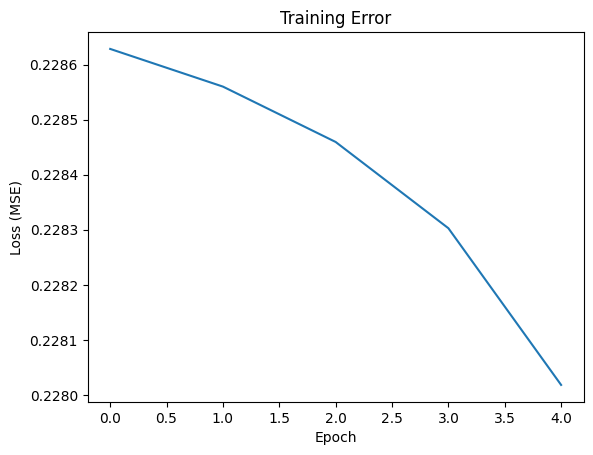

38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step
Testing DLMFRecommender (top 10)
Four example recommendations:
    User 1 -> <320:0.0197 939:0.019 2753:0.0189 1333:0.0187 1232:0.0187 2211:0.0184 3057:0.0182 3804:0.0172 3622:0.0171 318:0.0166>
    User 2 -> <3147:0.0202 886:0.0185 466:0.0184 2473:0.0181 248:0.0177 1732:0.0176 2464:0.0174 784:0.0171 750:0.0169 872:0.0166>
    User 3 -> <1617:0.0203 208:0.0202 1721:0.0186 3468:0.0182 3070:0.0174 3531:0.017 2542:0.017 3551:0.0169 1260:0.0167 2342:0.0167>
    User 4 -> <1102:0.0202 442:0.0197 1019:0.0194 2219:0.0193 1865:0.0192 2558:0.019 742:0.0187 191:0.0186 1165:0.0183 275:0.018>
Precision@10 = 0.023509933774834436
Recall@10 = 0.00627535324642281
--> elapsed time: 0:00:24 <--
-------------------------


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ users (InputLayer)  │ (None)            │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ items (InputLayer)  │ (None)            │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 50)        │    302,000 │ users[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_embedding      │ (None, 50)        │    185,300 │ items[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 50)        │          0 │ user_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 50)        │          0 │ item_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_dense (Dense)  │ (None, 50)        │      2,550 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_dense (Dense)  │ (None, 50)        │      2,550 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1)         │          0 │ user_dense[0][0], │
│                     │                   │            │ item_dense[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 492,400 (1.88 MB)

 Trainable params: 492,400 (1.88 MB)

 Non-trainable params: 0 (0.00 B)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


100%|██████████| 5/5 [00:24<00:00,  4.86s/epoch, loss=0.185]


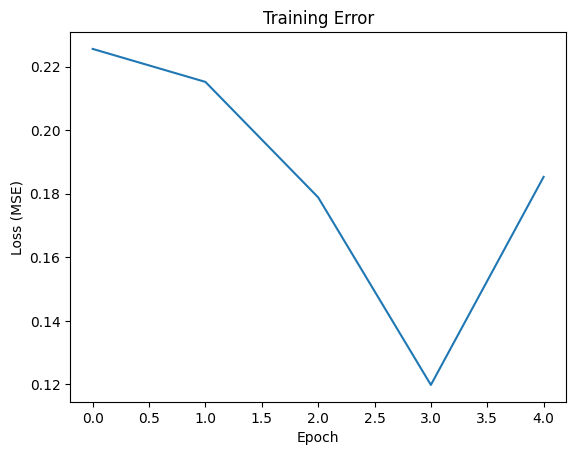

38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 173ms/step
Testing TwoTowerRecommender (top 10)
Four example recommendations:
    User 1 -> <858:0.4105 50:0.406 2997:0.4058 1923:0.3934 1240:0.3932 589:0.3912 3751:0.391 1210:0.3866 296:0.3824 3114:0.3776>
    User 2 -> <2997:0.653 1617:0.6078 318:0.606 1221:0.5995 608:0.5985 2762:0.5975 924:0.5968 858:0.5853 3114:0.5843 2396:0.5804>
    User 3 -> <318:0.4342 2762:0.4266 2028:0.4057 858:0.3966 457:0.3746 3578:0.3711 2396:0.366 296:0.3614 608:0.3579 3052:0.3565>
    User 4 -> <2858:0.3163 1617:0.2983 2797:0.2856 608:0.278 541:0.2734 3175:0.2713 1393:0.2703 593:0.2697 1094:0.2672 527:0.266>
Precision@10 = 0.12746688741721857
Recall@10 = 0.04551890153399358
--> elapsed time: 0:00:32 <--
-------------------------
Testing Ease (top 10)
Four example recommendations:
    User 1 -> <1148:0.4818 1688:0.4764 2565:0.466 2708:0.4592 588:0.451 2983:0.4496 1032:0.4389 1480:0.4337 2087:0.4201 1666:0.4121>
    User 2 -> <733:0.6353 1580:0.5979 3118:0.5714 1608:0.5678 957

Model: "GRU4Rec"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ GRU_1 (GRU)                     │ (32, 50)               │       563,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 3706)             │       189,006 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 752,706 (2.87 MB)

 Trainable params: 752,706 (2.87 MB)

 Non-trainable params: 0 (0.00 B)

None


  0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.0039 - loss: 118024.4062 - top3accuracy: 0.0131

 20%|██        | 1/5 [00:20<01:21, 20.32s/epoch, accuracy=0.00375, loss=1.18e+5, top3accuracy=0.0125]

100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 192ms/step - accuracy: 0.0039 - loss: 118019.3750 - top3accuracy: 0.0131
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 9.3140e-04 - loss: 116623.4141 - top3accuracy: 0.0109

 40%|████      | 2/5 [00:39<00:59, 19.80s/epoch, accuracy=0.00187, loss=1.16e+5, top3accuracy=0.0109]

100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 194ms/step - accuracy: 9.4074e-04 - loss: 116621.0391 - top3accuracy: 0.0109
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.0021 - loss: 115757.1562 - top3accuracy: 0.0134

 60%|██████    | 3/5 [00:58<00:39, 19.55s/epoch, accuracy=0.00313, loss=1.16e+5, top3accuracy=0.0125]

100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 192ms/step - accuracy: 0.0021 - loss: 115756.1328 - top3accuracy: 0.0134
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.0029 - loss: 115250.0938 - top3accuracy: 0.0128

 80%|████████  | 4/5 [01:18<00:19, 19.46s/epoch, accuracy=0.00438, loss=1.15e+5, top3accuracy=0.0128]

100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 193ms/step - accuracy: 0.0029 - loss: 115250.1016 - top3accuracy: 0.0128
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.0045 - loss: 114563.4219 - top3accuracy: 0.0157

100%|██████████| 5/5 [01:37<00:00, 19.38s/epoch, accuracy=0.005, loss=1.14e+5, top3accuracy=0.0156]  

100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 192ms/step - accuracy: 0.0045 - loss: 114559.0938 - top3accuracy: 0.0157


100%|██████████| 5/5 [01:37<00:00, 19.51s/epoch, accuracy=0.005, loss=1.14e+5, top3accuracy=0.0156]


Testing GRU4RecRecommender (top 10)
Four example recommendations:
    User 1 -> <64:0.2867 140:0.2739 99:0.2627 17:0.2407 80:0.2407 525:0.2274 8:0.2237 133:0.22 135:0.2199 533:0.2166>
    User 2 -> <64:0.2623 140:0.2518 150:0.2495 99:0.2435 17:0.2224 80:0.2207 525:0.2097 8:0.2078 135:0.2048 133:0.2041>
    User 3 -> <64:0.32 140:0.3028 150:0.2964 99:0.2883 80:0.2707 17:0.2665 525:0.2487 8:0.2474 133:0.2418 135:0.2366>
    User 4 -> <64:0.2806 140:0.2686 150:0.2662 99:0.2581 80:0.2374 17:0.237 525:0.2234 8:0.2221 135:0.2176 133:0.2146>
Precision@10 = 0.00026490066225165563
Recall@10 = 0.0026490066225165563
CategoricalAccuracy@1 = 0.0
CategoricalAccuracy@3 = 0.002152318
CategoricalAccuracy@10 = 1.0
--> elapsed time: 0:03:31 <--
-------------------------



Model: "Transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 50, 128)   │    474,496 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, 50, 128)   │      6,400 │ embedding[0][0]   │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 50, 128)   │        256 │ positional_embed… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 50, 128)   │    263,808 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 50, 128)   │          0 │ positional_embed… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 50, 128)   │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 50, 128)   │        256 │ dropout_1[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 50, 512)   │     66,048 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 50, 128)   │     65,664 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 50, 128)   │          0 │ dropout_1[0][0],  │
│                     │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 50, 128)   │          0 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 128)       │          0 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 3707)      │    478,203 │ get_item[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,355,131 (5.17 MB)

 Trainable params: 1,355,131 (5.17 MB)

 Non-trainable params: 0 (0.00 B)

None
You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


  0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch 1/5
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0053 - loss: 7.9876

 20%|██        | 1/5 [00:04<00:17,  4.42s/epoch, accuracy=0.00625, loss=7.81]

100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.0053 - loss: 7.9840
Epoch 2/5
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0077 - loss: 7.6233

 40%|████      | 2/5 [00:06<00:09,  3.10s/epoch, accuracy=0.00563, loss=7.58]

100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.0077 - loss: 7.6224
Epoch 3/5
 98/100 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0117 - loss: 7.0276

 60%|██████    | 3/5 [00:08<00:05,  2.66s/epoch, accuracy=0.00969, loss=7.04]

100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.0116 - loss: 7.0279
Epoch 4/5
 98/100 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0133 - loss: 7.0455

 80%|████████  | 4/5 [00:10<00:02,  2.47s/epoch, accuracy=0.0134, loss=6.97] 

100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.0133 - loss: 7.0431
Epoch 5/5
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0169 - loss: 6.6385

100%|██████████| 5/5 [00:13<00:00,  2.37s/epoch, accuracy=0.0162, loss=6.67]

100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.0169 - loss: 6.6391


100%|██████████| 5/5 [00:13<00:00,  2.62s/epoch, accuracy=0.0162, loss=6.67]


Testing TransformerRecommender (top 10)
Four example recommendations:
    User 1 -> <2011:0.0057 2627:0.0052 1616:0.0049 2761:0.0044 3526:0.0042 2616:0.0037 3551:0.0037 2857:0.0035 3867:0.0033 2354:0.0033>
    User 2 -> <3808:0.0221 3272:0.01 2395:0.0094 3767:0.0075 2391:0.0063 3670:0.006 2715:0.0056 1916:0.0053 3395:0.005 2718:0.005>
    User 3 -> <2761:0.0438 3526:0.0242 3867:0.016 3792:0.0158 2627:0.0155 3702:0.0145 3752:0.0137 3701:0.0128 1616:0.0127 2790:0.0125>
    User 4 -> <3255:0.0506 2570:0.0297 1616:0.0295 3526:0.0255 2616:0.0181 2761:0.018 3159:0.0141 2627:0.0129 3174:0.0129 3752:0.012>
Precision@10 = 0.0009602649006622518
Recall@10 = 0.009602649006622516
CategoricalAccuracy@1 = 0.12798013
CategoricalAccuracy@3 = 0.33129138
CategoricalAccuracy@10 = 1.0
--> elapsed time: 0:00:22 <--
-------------------------


Model: "Transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 50, 128)   │    474,496 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, 50, 128)   │      6,400 │ embedding_2[0][0] │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 50, 128)   │        256 │ positional_embed… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 50, 128)   │    263,808 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 50, 128)   │          0 │ positional_embed… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 50, 128)   │          0 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 50, 128)   │        256 │ dropout_4[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 50, 512)   │     66,048 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 50, 128)   │     65,664 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 50, 128)   │          0 │ dropout_4[0][0],  │
│                     │                   │            │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 50, 128)   │          0 │ add_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 50, 128)   │        256 │ dropout_5[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 50, 128)   │    263,808 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 50, 128)   │          0 │ dropout_5[0][0],  │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 50, 128)   │          0 │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 50, 128)   │        256 │ dropout_7[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 50, 512)   │     66,048 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 50, 128)   │     65,664 │ dense_6[0][0]   

 Total params: 1,751,163 (6.68 MB)

 Trainable params: 1,751,163 (6.68 MB)

 Non-trainable params: 0 (0.00 B)

None
You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


  0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.0045 - loss: 8.0110

 20%|██        | 1/5 [00:07<00:30,  7.72s/epoch, accuracy=0.005, loss=7.84]

100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.0045 - loss: 8.0093
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.0073 - loss: 7.6888

 40%|████      | 2/5 [00:11<00:16,  5.52s/epoch, accuracy=0.005, loss=7.64]

100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.0072 - loss: 7.6883
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.0069 - loss: 7.0744

 60%|██████    | 3/5 [00:15<00:09,  4.85s/epoch, accuracy=0.0075, loss=7.14]

100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.0069 - loss: 7.0750
Epoch 4/5
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.0098 - loss: 7.1848

 80%|████████  | 4/5 [00:19<00:04,  4.57s/epoch, accuracy=0.00906, loss=7.09]

100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.0098 - loss: 7.1829
Epoch 5/5
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.0156 - loss: 6.7822

100%|██████████| 5/5 [00:23<00:00,  4.36s/epoch, accuracy=0.0122, loss=6.83] 

100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.0155 - loss: 6.7831


100%|██████████| 5/5 [00:23<00:00,  4.78s/epoch, accuracy=0.0122, loss=6.83]


Testing TransformerRecommender (top 10)
Four example recommendations:
    User 1 -> <3498:0.009 3362:0.0089 3896:0.0078 3670:0.0067 2986:0.0067 1392:0.0057 3749:0.0056 2699:0.0052 3577:0.0052 2761:0.0051>
    User 2 -> <2806:0.0146 180:0.0106 3801:0.0101 1830:0.0093 2001:0.0092 1421:0.0078 1881:0.0077 2642:0.0075 3766:0.0075 2392:0.0073>
    User 3 -> <3362:0.0099 3420:0.0097 3896:0.0092 3702:0.0063 2699:0.0056 1999:0.0055 2986:0.0048 2627:0.0047 3749:0.0045 2173:0.0044>
    User 4 -> <2984:0.0068 180:0.0065 1881:0.0064 2642:0.0059 2627:0.0058 3701:0.0054 3623:0.0054 2950:0.0053 2477:0.0051 3840:0.005>
Precision@10 = 0.000794701986754967
Recall@10 = 0.007947019867549669
CategoricalAccuracy@1 = 0.13592716
CategoricalAccuracy@3 = 0.3213576
CategoricalAccuracy@10 = 1.0
--> elapsed time: 0:00:34 <--
Done.


In [9]:
import datetime, time
import warnings
warnings.filterwarnings("ignore")

class CategoricalAccuracy(Metric):
    def __init__(self, test, cutoff=np.inf):
        super().__init__(cutoff)
        dataset = from_ratings_to_sequences(test)
        y_true = np.empty(shape = (len(dataset), 1))
        for i in range(y_true.shape[0]):
            y_true[i, :] = dataset[i][:1]
        self.y_true = tf.constant(y_true, dtype = tf.float32)

    def compute(self, recommendation):
        y_pred = tf.constant(recommendation.ranked_iidx(), dtype = tf.float32)
        acc = (tf.reduce_sum(tf.keras.metrics.top_k_categorical_accuracy(self.y_true, y_pred, k = self.cutoff)) / self.y_true.shape[0]).numpy()
        return acc


# Test data structures and algorithms on a dataset.
def test(ratings_file, topn=np.inf, cutoff=np.inf, threshold=1, sep=','):
    print(colored(f'Reading the data at ' + time.strftime('%X...'), 'blue'))
    start = time.time()
    ratings = Ratings(ratings_file, sep)
    print(f'Ratings matrix takes {round(10 * ratings.matrix().nbytes / 1024 / 1024) / 10:,} MB in RAM')
    timer(start)

    # Produce a rating split and test a set of recommenders. 
    train, test = ratings.random_split(0.8)
    train_temp, test_temp = ratings.peruser_sequence_split(ntestitems=1)
    metrics = [Precision(test, cutoff=cutoff, threshold=threshold), Recall(test, cutoff=cutoff, threshold=threshold)]
    metrics_temp = [Precision(test_temp, cutoff=cutoff, threshold=threshold), Recall(test_temp, cutoff=cutoff, threshold=threshold), CategoricalAccuracy(test_temp, cutoff=1), CategoricalAccuracy(test_temp, cutoff=3), CategoricalAccuracy(test_temp, cutoff=cutoff)]
    run_recommenders(train, metrics, topn)
    run_temp_recommenders(train_temp, metrics_temp, topn)


# Run some recommenders on the some rating data as input - no evaluation.
def run_recommenders(train, metrics, topn):
    print('-------------------------')
    start = time.time()
    run_recommender(DLMFRecommender(train, nepochs=5), metrics, topn)
    start = timer(start)
    
    print('-------------------------')
    run_recommender(TwoTowerRecommender(train, nepochs=5), metrics, topn)
    start = timer(start)
    
    print('-------------------------')
    run_recommender(Ease(train, threshold=1), metrics, topn)
    timer(start)

def run_temp_recommenders(train, metrics, topn):
    print('-------------------------')
    start = time.time()
    run_recommender(GRU4RecRecommender(train, nepochs=5, session_length=None, batch_size=32), metrics, topn)
    start = timer(start)
    
    print('-------------------------')
    run_recommender(TransformerRecommender(train, nlayers=1), metrics, topn)
    start = timer(start)
    
    print('-------------------------')
    run_recommender(TransformerRecommender(train, nlayers=2), metrics, topn)
    timer(start)

# Run a recommender and evaluate a list of metrics on its output.
def run_recommender(recommender, metrics, topn):
    print(f'Testing {recommender} (top {topn})')
    recommendation = recommender.recommend(topn)
    print('Four example recommendations:\n' + recommendation.display(4))
    for metric in metrics:
        print(metric, '=', metric.compute(recommendation))

from termcolor import colored
def timer(start):
    print(colored(f'--> elapsed time: {datetime.timedelta(seconds=round(time.time() - start))} <--', 'blue'))
    return time.time()
    
np.random.seed(0)
print('=========================\nTesting MovieLens \'1 million\' dataset')
test('data/ratings-1m.dat', topn=10, cutoff=10, sep='::')
print('=========================\nDone.')

# Additional testing?
student_test()